In [456]:
from sklearn.datasets import load_iris
import pandas as pd
import math
import numpy as np

In [457]:
#load iris dataset
data_iris = load_iris()
iris_X, iris_y = load_iris(return_X_y=True)
feature_iris = data_iris['feature_names']

In [458]:
#transform iris into dataframe
iris_X=pd.DataFrame(iris_X)
iris_y=pd.DataFrame(iris_y)

In [459]:
iris_X.rename(columns = {0:feature_iris[0],1:feature_iris[1],2:feature_iris[2],3:feature_iris[3]}, inplace = True)
iris_y.rename(columns = {0:"target"}, inplace = True) 

In [460]:
def rangeFeature(data):
    return data.min(),data.max()

In [461]:
def setRange(data):
    dataMin = []
    dataMax = []
    for index,col in enumerate(data.columns):
        tmpMin,tmpMax=rangeFeature(data[col])
        dataMin.append(tmpMin)
        dataMax.append(tmpMax)
    return dataMin,dataMax

In [462]:
def initCentroid(cluster,dimension,dataMin,dataMax):
    centroid = []
    for i in range(cluster):
        point = []
        for j in range(dimension):
            pos = np.random.uniform(dataMin[j],dataMax[j])
            point.append(pos)
        centroid.append(point)
    return centroid

In [463]:
type(iris_X.loc[0].values)

numpy.ndarray

In [464]:
def distFromCentroid(point1,point2):
    sumSquare = 0
    dimension = len(point1)
    for i in range(dimension):
        sumSquare += (point1[i]-point2[i])**2
    return sumSquare ** 0.5

In [465]:
def checkDistCentroid(centroid,data,cluster):
    distAllCentroid = []
    lenData = len(data)
    
    for i in range(cluster):
        distCentroid = []
        for j in range(lenData):
            dist = distFromCentroid(data.loc[j].values,centroid[i])
            distCentroid.append(dist)
        distAllCentroid.append(distCentroid)
    return distAllCentroid

In [466]:
def checkCluster(dist,cluster):
    mn = dist[0]
    idx = 0
    for i in range(1,cluster):
        if (mn>dist[i]):
            mn = dist[i]
            idx = i
    return idx

In [467]:
def clustering(distance,cluster,lenData):
    clusterNow = []
    for i in range(lenData):
        clusterNow.append(checkCluster(distance[i],cluster))
    return clusterNow

In [468]:
def moveCentroid(cluster,data):
    lenData = len(data)
    cntCluster = max(cluster) + 1
    centroid = []
    
    for i in range(cntCluster):
        cnt = 0
        point = [0]*len(data.columns)
        # get sum of coordinate one cluster
        for j in range(lenData):
            if (cluster[j]==i):
                cnt+=1
                for k,col in enumerate(data.columns):
                    point[k] += data.loc[j][col]
        # get average of coordinate one cluster
        for j in range(len(data.columns)):
            if (cnt != 0):
                point[j] /= cnt 
        centroid.append(point)
    return centroid

In [469]:
def kmeans(data,cluster):
    dataMin = []
    dataMax = []
    centroid = []
    distance = []
    lenData = len(data)
    clusterNow = []
    prevCluster = []
    
    # set range every columns
    dataMin,dataMax = setRange(data)
    # inisialize centroid
    centroid = initCentroid(cluster,len(data.columns),dataMin,dataMax)
    # check distance from centroid
    distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
    # clustering
    clusterNow = clustering(distance, cluster, lenData)
    
    while(clusterNow != prevCluster):
        prevCluster = clusterNow
        centroid = moveCentroid(clusterNow,data)
        distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
        clusterNow = clustering(distance, cluster, lenData)
    return clusterNow

In [470]:

# data

### Visualization k-means
Kami menggambar dalam 2 dimensi untuk setiap pasangan kolom (column1 dan column2) yang mungkin dari dataset yang diberikan. Kemudian hasil clustering direpresentasikan sebagai warna yang berbeda.

In [471]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualization_k_means(train_data, number_of_cluster):
    clustering_result = kmeans(train_data, number_of_cluster)
    clustering_res = pd.DataFrame(clustering_result)
    data = pd.concat([iris_X, clustering_res], axis=1)
    data.rename(columns={0:"clustering_result"}, inplace = True)
    column_name = train_data.columns
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

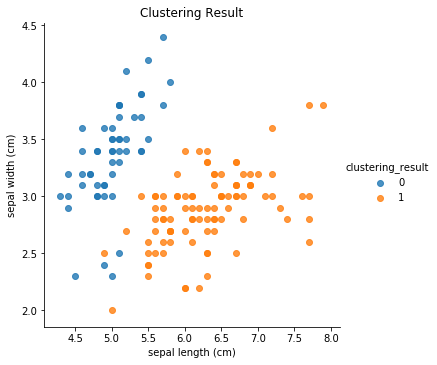

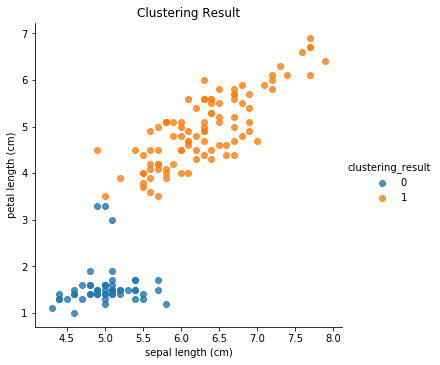

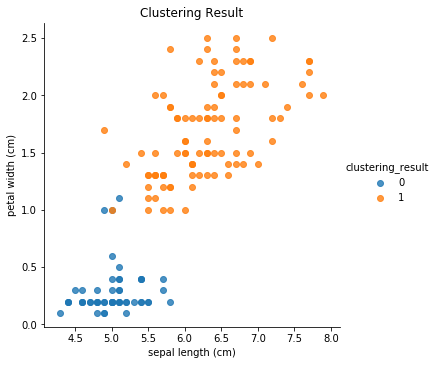

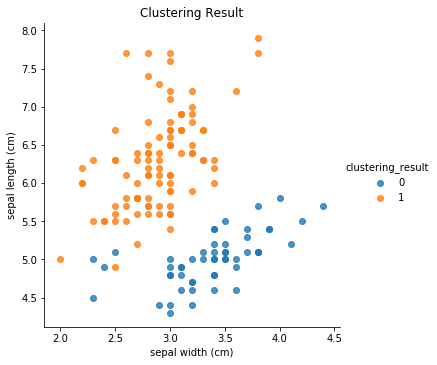

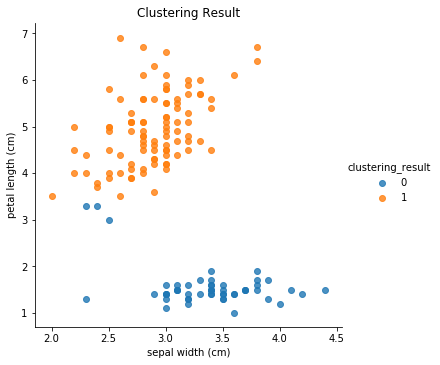

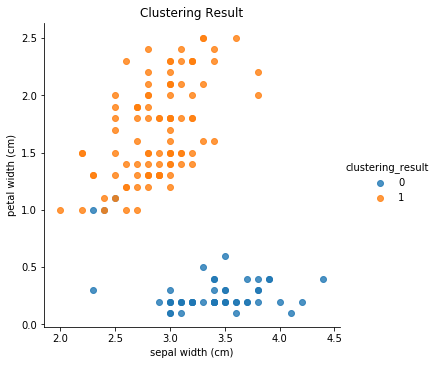

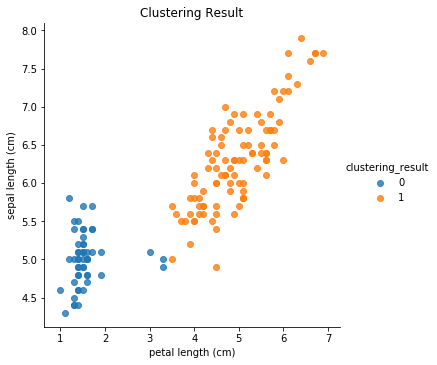

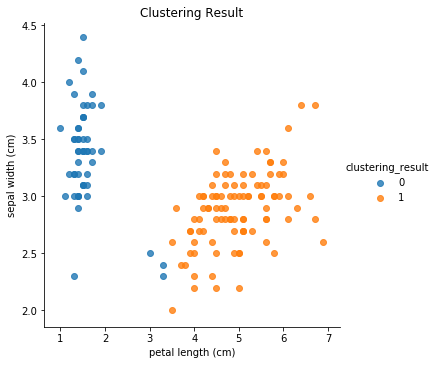

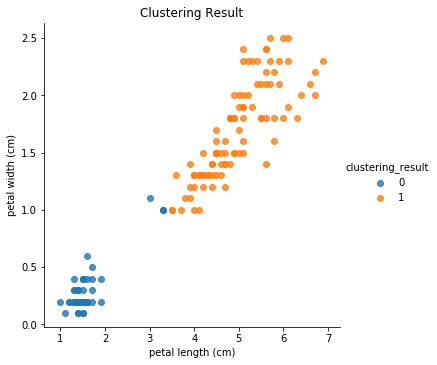

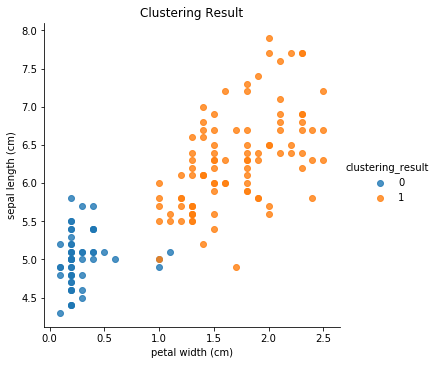

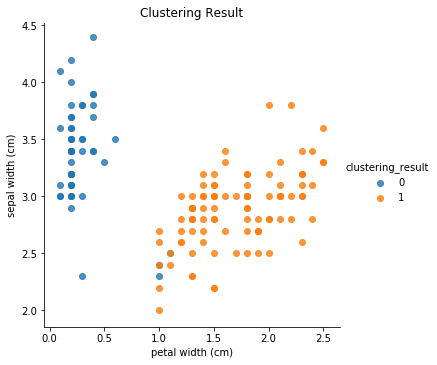

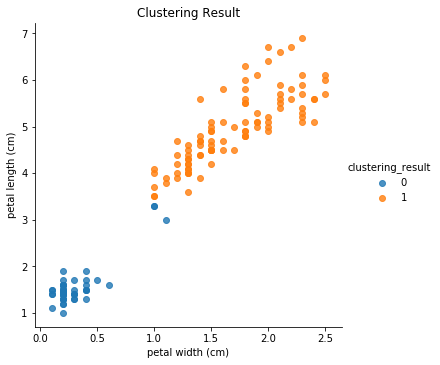

In [472]:
visualization_k_means(iris_X, 2)

In [473]:
def euclidean_dist(point1, point2):
    distance = 0
    dimension = len(point1)
    
    for i in range(dimension):
        distance += (point1[i]-point2[i])**2
        
    return distance ** 0.5

In [474]:
def init_proximity_matrix(data):
    matrix = [[0 for i in range(len(data))] for j in range(len(data))]
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            if (i != j):
                proximity = euclidean_dist(data.loc[i].values, data.loc[j].values)
                matrix[i][j] = proximity
                matrix[j][i] = proximity
    
    return matrix

In [475]:
def init_cluster(n_cluster):
    clusters = []
    
    for i in range(n_cluster):
        clusters.append(str(i))
        
    return clusters

In [476]:
def find_shortest_dist(proximity_matrix):
    min_distance = float("inf")
    result = [0, 1]
    
    for i in range(len(proximity_matrix)):
        for j in range(i, len(proximity_matrix)):
            if (proximity_matrix[i][j] > 0) and (proximity_matrix[i][j] < min_distance):
                min_distance = proximity_matrix[i][j]
#                 print(min_distance)
                result[0] = i
                result[1] = j
    
    return result

In [477]:
def update_clusters(clusters, cluster1, cluster2):
    updated_clusters = []
    
    for i in range(len(clusters)-1):
        if (i != cluster1):
            if (i >= cluster2):
                updated_clusters.append(clusters[i+1])
            else:
                updated_clusters.append(clusters[i])
        else:
            updated_clusters.append(clusters[cluster1] + "," + clusters[cluster2])
    
    return updated_clusters

In [478]:
def update_proximity_matrix(matrix, cluster1, cluster2, linkage):
    updated_matrix = [[0 for i in range(len(matrix)-1)] for j in range(len(matrix)-1)]

    for i in range(len(updated_matrix)):
        if (i != cluster1):
            idx_i = i
            if (i >= cluster2):
                idx_i += 1

            for j in range(idx_i, len(updated_matrix)):
                if (i != j):
                    if (j != cluster1):
                        if (j >= cluster2):
                            updated_matrix[i][j] = matrix[idx_i][j+1]
                            updated_matrix[j][i] = matrix[idx_i][j+1]
                        else:
                            updated_matrix[i][j] = matrix[idx_i][j]
                            updated_matrix[j][i] = matrix[idx_i][j]
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])

        else:
            for j in range(i, len(updated_matrix)):
                if (i != j):
                    if (j >= cluster2):
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                        
    return updated_matrix

In [479]:
def MakeMatrix(size):
    return [["" for i in range (size)] for j in range(size)]

In [480]:
def agglomerative(data, cluster, linkage):
    n_cluster = len(data)
    proximity_matrix = init_proximity_matrix(data)
    clusters = init_cluster(n_cluster)
#     n_cluster = 6
#     proximity_matrix = [[0.00, 0.71, 5.66, 3.61, 4.24, 3.20], [0.71, 0.00, 4.95, 2.92, 3.54, 2.50], [5.66, 4.95, 0.00, 2.24, 1.41, 2.50], [3.61, 2.92, 2.24, 0.00, 1.00, 0.50], [4.24, 3.54, 1.41, 1.00, 0.00, 1.12], [3.20, 2.50, 2.50, 0.50, 1.12, 0.00]]
#     clusters = ['a', 'b', 'c', 'd', 'e', 'f']
#     n_cluster = 4
#     proximity_matrix = [[0, 1, 4, 5], [1, 0, 2, 6], [4, 2, 0, 3], [5, 6, 3, 0]]
#     clusters = ['a', 'b', 'c', 'd']
    
    if (len(data) > 1):
        idx_row = 0;
        mat_size = len(data)
        mat = MakeMatrix(mat_size)
#         print("mat size")
#         print(mat_size)
#         print(mat[1][1])
#         print("cluster")
#         print(clusters)
#         print(clusters[0])
#         print(clusters[0])
        for i in range(mat_size):
            mat[idx_row][i] = clusters[i]

        while (n_cluster > cluster):             
            cluster_pair = find_shortest_dist(proximity_matrix)
#             print(cluster_pair)

#             print(clusters)
#             print(type(cluster_pair[0]))
            
            for i in range(mat_size):
                mat[idx_row+1][i] =  mat[idx_row][i]
            
            pos_1 = -999
            pos_2 = -999
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[0]]):
                    pos_1 = i
                    break
            
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[1]]):
                    pos_2 = i
                    break
            
            
            pos_left = min(pos_1, pos_2)
            pos_right = max(pos_1, pos_2)
            mat[idx_row+1][pos_left] = mat[idx_row+1][pos_left] + "," + mat[idx_row+1][pos_right]
            mat[idx_row+1][pos_right] = ""
            
#             print("idx_row")
#             print(idx_row+1)
#             print(mat)
            
            clusters = update_clusters(clusters, cluster_pair[0], cluster_pair[1])  
            proximity_matrix = update_proximity_matrix(proximity_matrix, cluster_pair[0], cluster_pair[1], linkage)
            
            n_cluster -= 1
            idx_row +=1
            offset = data
    return clusters, mat, len(data) - cluster

In [481]:
agglo_result = agglomerative(iris_X, 2, "complete")
print(agglo_result[1][147])

['0,17,40,7,39,49,27,28,4,37,35,1,45,12,9,34,25,29,30,2,3,47,42,6,8,38,13,22,41,5,18,10,48,36,20,31,11,24,23,26,43,19,21,46,44,14,15,16,32,33', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '50,52,86,77,54,58,76,65,75,51,56,85,63,91,78,73,74,97,68,87,119,70,127,138,149,101,113,142,121,114,72,83,133,123,126,111,146,134,100,136,148,120,143,124,140,144,103,116,137,104,128,132,108,110,147,115,112,139,141,145,102,125,129,107,130,105,122,118,109,135,117,131', '', '', '53,89,69,80,81,59,64,79,62,55,90,66,84,61,71,67,82,92,88,95,96,94,99,106,57,93,98,60', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [482]:
import numpy as np
print(agglo_result[1][148][2])
df = pd.DataFrame(agglo_result[1])
# df
df.to_csv("try.csv", sep='\t', encoding='utf-8')
# df

In [483]:
temp = agglo_result[1]
for i in range(len(temp)):
    check = 0
    for j in range(len(temp)-1):
        if ((temp[j][i] == temp[j+1][i]) & (check == 0)):
            check = 1
        elif ((temp[j][i] != temp[j+1][i]) & (check == 1)):
            check = 0
        else:
            temp[j][i] = "|"

In [484]:
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

## Dendogram
Dendogram tidak ditampilkan karena ukurannya sangat rumit sekali. Bahkan dataset iris yang memiliki 150 instance akan sangat rumit dendogramnya. Oleh karena itu kami menyimpan dendogram dalam file csv

In [485]:
# create dendogram and save into file dendogram.csv


print(agglo_result[1][148][2])
df = pd.DataFrame(temp, columns=headers)
# df
df.to_csv("dendogram.csv", sep='\t', encoding='utf-8')
# df

|


In [486]:
def get_dict_agglo_cluster_result(agglo_result_string):
    agglo_cluster_result = {}
    i = 1
    for data in agglo_result_string:
        temp = data.split(",")
        for instance in temp:
            agglo_cluster_result[int(instance)] = i
        i = i+1
    return agglo_cluster_result

In [487]:
import copy
def display(train_data, dic_target):
    data_result = copy.deepcopy(train_data)
    column_name = train_data.columns
    data_result["clustering_result"] = 0
    for key, value in dic_target.items():
        data_result["clustering_result"][key] = value;
    
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data_result, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

In [488]:
def visualization_agglo_result(train_data, num_cluster, linkage):
    dic_target = get_dict_agglo_cluster_result(agglomerative(iris_X, num_cluster, linkage)[0])
    display(train_data, dic_target)

#### Note : To get desired visualizion aggloromerative result
Please run it in order from line cell that defined function get_dict_agglo_cluster_result(agglo_result_string)

/home/fajar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


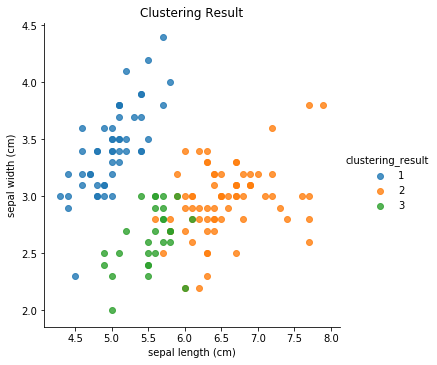

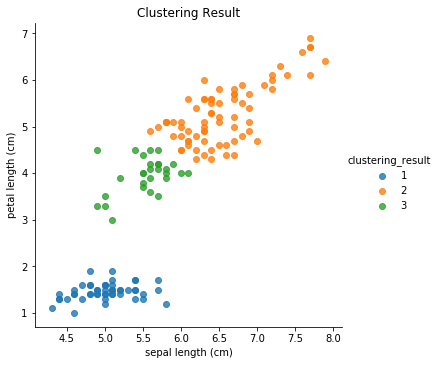

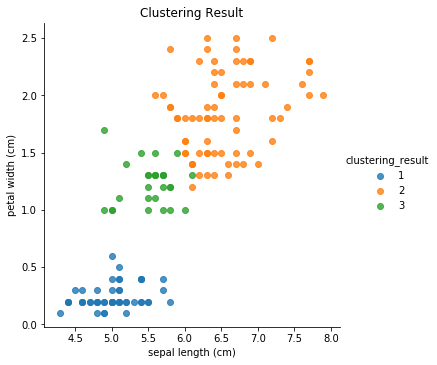

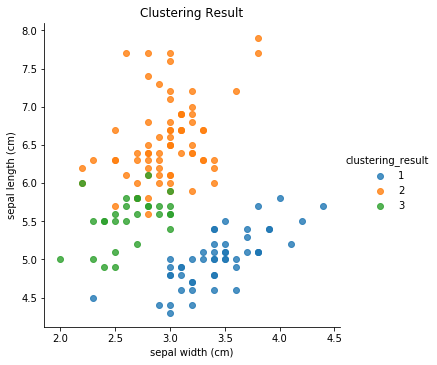

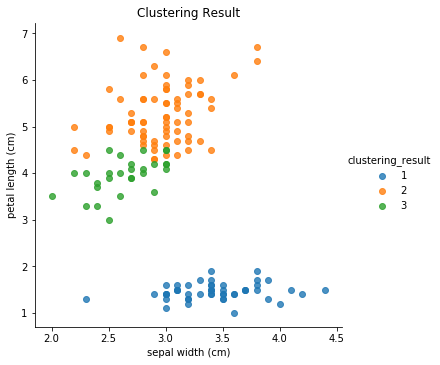

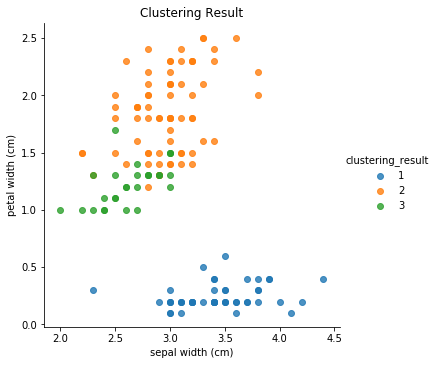

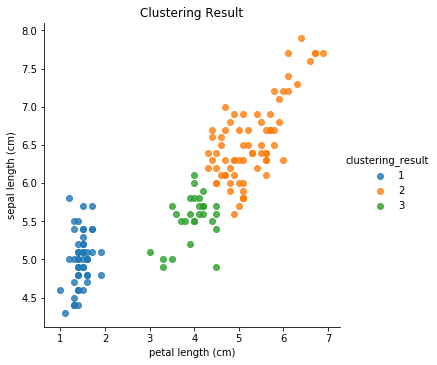

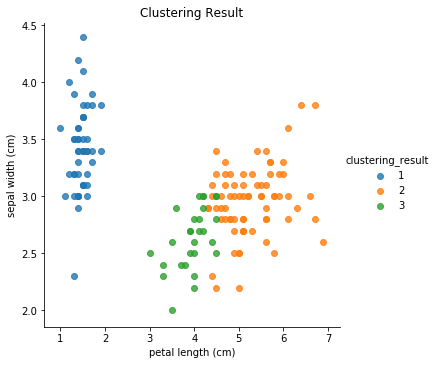

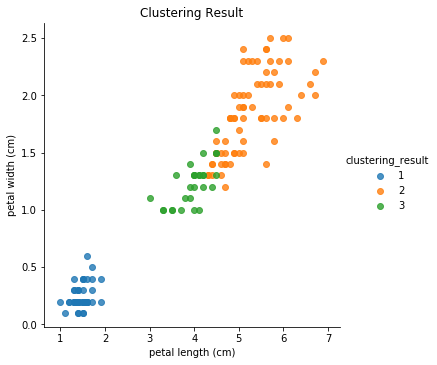

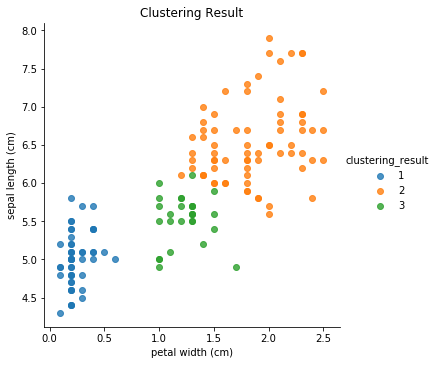

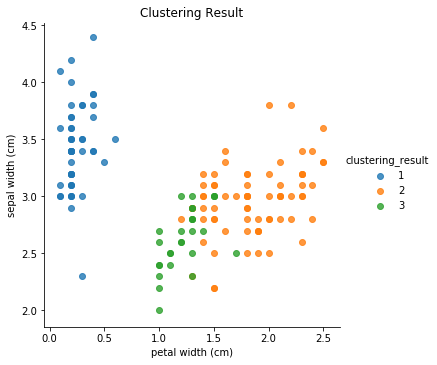

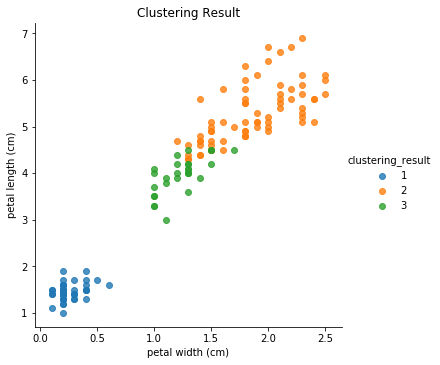

In [489]:
visualization_agglo_result(iris_X, 3, "complete")